In [7]:
%matplotlib inline

In [2]:
import os
import csv
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data
import glob
import metpy.calc as mpcalc
import datetime
import matplotlib.units as munits
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio

from scipy.optimize import curve_fit
# from netCDF4 import Dataset
from matplotlib import colors as mcolors
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime, timedelta

print('Done importing modules now')

Done importing modules now


## Define days to read in


In [11]:

day_start = '20221111'   # between March 13 and March 31 (inclusive) But NOT 20150318 due to a data gap late in the day on the 18th
day_end = '20231106'   # between March 13 and March 31 (inclusive) But NOT 20150318 due to a data gap late in the day on the 18th

# n_files = int(day_end[6:8])-int(day_start[6:8])

# print(n_files)


## Collect data from lidar data files

In [85]:
# ## import local routines

# sys.path.append('./utils/') 

# from wc_writeNetCDF import list_files, wcFiles_to_NetCDF
# from lidar_plot_routines import get_wspd_wdir, lidar_plots, lidar_plots2


In [12]:
def define_lidar_file(day_start, day_end):
    """Figure out which lidar file(s) is/are needed to match this day. 
    
    Parameters
    ----------
    day_start :  string of YYYYMMDD
    day_end :  string of YYYYMMDD

    Returns
    ------
    lidar_filenames : string of WC v2 sta filenames for XPIA
    """

    n_files = int(day_end[6:8])-int(day_start[6:8])
    #This procedure assumes all data within the same month - sloppy but effective for this exercize

    
    # Better?
    start_date = datetime.strptime(day_start, "%Y%m%d")
    end_date = datetime.strptime(day_end, "%Y%m%d")

    
# Calculate the difference in days
    date_difference = (end_date - start_date).days
    n_files = date_difference
# print("Number of days between the dates:", date_difference)
    
    date_list = [(start_date + timedelta(days=i)).strftime("%Y%m%d")
             for i in range((end_date - start_date).days + 1)]
    
    # Generate a list of dates with prefix and suffix
    # Define prefix and suffix
    prefix = "WLS7-0068_"
    suffix = "__00_00_00.sta"

    lidar_filenames = [f"{prefix}{(start_date + timedelta(days=i)).strftime('%Y_%m_%d')}{suffix}"
             for i in range((end_date - start_date).days + 1)]
    
#     for f in range(n_files):
#         this_day = str(int(day_start[6:8])+f)
#         this_month = str(int(day_start[4:6]))
#         this_year = str(int(day_start[0:4]))

#         print('this_year',this_year)
#         if len(this_day) == 1: this_day = '0'+str(int(day_start[6:8])+f)
#         if len(this_month) == 1: this_month = '0'+str(int(day_start[4:6]))

        
#         print('this_month:', this_month)
#         print(f,'this_day:',this_day)
#         lidar_filenames_f = 'WLS866-16_2015_03_'+this_day+'__00_00_00.sta' 
#         lidar_filenames_f = 'WLS7-0068_2023_'+this_month+'_'+this_day+'__00_00_00.sta' 
#         lidar_filenames_f = 'WLS7-0068_'+this_year+'_'+this_month+'_'+this_day+'__00_00_00.sta' 
# #         lidar_filenames_f = 'WLS7-0068_2023_04_03__00_00_00.sta' 
# #         print(lidar_filenames_f)
#         lidar_filenames.append(lidar_filenames_f)
        
    return lidar_filenames


In [13]:
def list_files(file_pattern,path,file_count=None):
    """ 
    return list of files matching pattern in path directory
    
    Arguments:
    file_pattern: glob pattern for filename, e.g. 'WLS866-16_2015_04_0*__00_00_00.rtd'
    path: path to directory to search
    file_count: number of files to include from end of list, default 'None' returns all
    
    Output:
    sorted list of files including full path
    
    """
    import os
    import glob
    
    assert os.path.isdir(path)
    if path[-1] != '/':
        path = path+'/'
    
    sorted_files = sorted(glob.iglob(path + file_pattern)) #, reverse=True)
    if file_count is None:
        return sorted_files
    
    else:
        return (sorted_files[:-file_count-1:-1])[::-1]

def wcFiles_to_NetCDF(file,zvars=None,outfile=None):
    import re
    import pandas as pd
    import xarray as xr
    
    # Read off header size and process some of the header data
    f = open(file, encoding='iso-8859-1', buffering=1)  # thanks Leosphere 
    header1 = f.readline()
    assert 'HeaderSize' in header1 or 'HeaderLength' in header1
    headersize = (int)(re.findall(r'\d+', header1)[0])

    lines = []
    for l in range(headersize):
        lines.append(f.readline())

    try:
        alt = [i for i in lines if 'Altitudes' in i][0]
        hgts = [int(s) for s in re.findall(r'\d+', alt)]
        print("Now Getting these heights [m]",hgts)
    except:
        print('ERROR: Cannot find list of altitudes in file header')
        return None

    f.close()

    # Read deliminated file (may need to do some pre-processing in vi to clean up)
#     data = pd.read_csv(file, skiprows=headersize+1, sep='\t', encoding='iso-8859-1', \
#                       header=0, parse_dates=True, index_col=0)
#     parser = lambda date: pd.datetime.strptime(date, '%d%b%Y')
#     '01/04/2023 00:02:00'
    parser = lambda date: pd.datetime.strptime(date, '%d/%m/%Y %H:%M:%S')
    data = pd.read_csv(file, skiprows=headersize+1, sep='\t', encoding='iso-8859-1', \
                      header=0, parse_dates=[0], date_parser=parser, index_col=0)
    

#     data.index.name='Time'
    data.index.name='Date'
#     print(data.index.values)

    dropnames = ['Unnamed','Wiper','Temp']
    dropnames = ['WiperCount','Tm'] #JKL
    for var in data.columns.values.tolist():
        for drop in dropnames:
            if drop in var:
                data.drop(axis=1,labels=[var],inplace=True)

    names = data.columns.values.tolist()
#     print('68 Names: ',names)
    startidx = len(names)%len(hgts)
    nfields = (int)(len(names)/len(hgts))
    print('nfields:',nfields)
    
    if zvars is None:
        print('inside zvars is None')
        seppatterns = [re.compile('[0-9]+m '),re.compile('-[0-9]+')]
        seppatterns = [re.compile('[1-10] '),re.compile('-[1-10]+')]
        seppatterns = [re.compile('1')]
        zvars = []
        for v in names[startidx:startidx+nfields]:
            for sep in seppatterns:
                print('v:',v)
                print('sep:',sep)
                try:
                    zvars.append( v.replace( re.search(sep, v).group(0), '' ) )
                except:
                    continue
        print('len(zvars):',len(zvars))  
        print('nfields:',nfields)
        if len(zvars) != nfields:
            print('ERROR: Failure recovering variable names collected at each elevation')
            return None
                        
    
    da = xr.DataArray(data.values[:,startidx::nfields], coords=[data.index.values, hgts], dims=['time', 'height'])
    ds = da.to_dataset(name = zvars[0])
    for v in range(1,len(zvars)):
        ds[zvars[v]] = xr.DataArray(data.values[:,startidx+v::nfields], coords=[data.index.values, hgts], dims=['time', 'height'])
        
    for v in range(startidx):
        ds[names[v]] = xr.DataArray(data.values[:,v], coords=[data.index.values], dims=['time'])

    for line in lines:
        splt = line.split('=')
        if len(splt) > 1:
            ds.attrs[splt[0]]=splt[1][:-1]
        
    if outfile is not None:
        ds.to_netcdf(path=outfile)
        
    return ds



In [ ]:
lidar_filenames = define_lidar_file(day_start,day_end)
# lidar_filenames = list_files('WLS7-0068_*','/pl/active/JKL_OBS/AWAKEN/WC68/',file_count=None)
# print(day_start)

print("Reading these lidar files:",lidar_filenames)
# print('/pl/active/JKL_OBS/AWAKEN/WC68/WLS7-0068_2023_04_10__00_00_00.sta')

path_in = '/pl/active/JKL_OBS/AWAKEN/WC68/' #'PATH_TO_DATA/WC16/RTD/'



In [ ]:
# zvars = ['CNR', 'RWS', 'RWSD', 'WSP', 'WDIR', 'u', 'v', 'w']
zvars = ['Vhm', 'dVh', 'Azim1', 'um', 'du', 'vm', 'dv', 'wm',
        'dw', 'CNR', 'Avail']

zvars = ['Vhm', 'dVh', 'Azim1', 'um', 'du', 'vm', 'dv', 'wm',
        'dw', 'CNR', 'Avail']

# For v1 files:
# Date    WiperCount      Tm      Vhm1    dVh1    VhMax1  VhMin1  Azim1   um1     du1     vm1     dv1     wm1     dw1     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.1         Vhm2    dVh2    VhMax2  VhMin2  Azim2   um2     du2     vm2     dv2     wm2     dw2     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.2         Vhm3    dVh3    VhMax3  VhMin3  Azim3   um3     du3     vm3     dv3     wm3     dw3     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.3         Vhm4    dVh4    VhMax4  VhMin4  Azim4   um4     du4     vm4     dv4     wm4     dw4     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.4         Vhm5    dVh5    VhMax5  VhMin5  Azim5   um5     du5     vm5     dv5     wm5     dw5     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.5         Vhm6    dVh6    VhMax6  VhMin6  Azim6   um6     du6     vm6     dv6     wm6     dw6     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.6         Vhm7    dVh7    VhMax7  VhMin7  Azim7   um7     du7     vm7     dv7     wm7     dw7     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.7         Vhm8    dVh8    VhMax8  VhMin8  Azim8   um8     du8     vm8     dv8     wm8     dw8     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.8         Vhm9    dVh9    VhMax9  VhMin9  Azim9   um9     du9     vm9     dv9     wm9     dw9     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.9         Vhm10   dVh10   VhMax10 VhMin10 Azim10  um10    du10    vm10    dv10    wm10    dw10    CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.10
zvars = ['Vhm', 'dVh', 'VhMax','VhMin', 'Azim', 'um', 'du', 'vm', 'dv', 'wm', 'dw', 'CNRm', 'dCNR', 
         'CNRmax',  'CNRmin',  'spectral_broadening',     'dspectral_broadening',    'Avail'] #.1         Vhm2    dVh2    VhMax2  VhMin2  Azim2   um2     du2     vm2     dv2     wm2     dw2     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.2         Vhm3    dVh3    VhMax3  VhMin3  Azim3   um3     du3     vm3     dv3     wm3     dw3     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.3         Vhm4    dVh4    VhMax4  VhMin4  Azim4   um4     du4     vm4     dv4     wm4     dw4     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.4         Vhm5    dVh5    VhMax5  VhMin5  Azim5   um5     du5     vm5     dv5     wm5     dw5     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.5         Vhm6    dVh6    VhMax6  VhMin6  Azim6   um6     du6     vm6     dv6     wm6     dw6     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.6         Vhm7    dVh7    VhMax7  VhMin7  Azim7   um7     du7     vm7     dv7     wm7     dw7     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.7         Vhm8    dVh8    VhMax8  VhMin8  Azim8   um8     du8     vm8     dv8     wm8     dw8     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.8         Vhm9    dVh9    VhMax9  VhMin9  Azim9   um9     du9     vm9     dv9     wm9     dw9     CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.9         Vhm10   dVh10   VhMax10 VhMin10 Azim10  um10    du10    vm10    dv10    wm10    dw10    CNRm    dCNR    CNRmax  CNRmin  spectral_broadening     dspectral_broadening    Avail.10



ds_list = []
for f in lidar_filenames:
#     ds_list.append(wcFiles_to_NetCDF(path_in+f))
    ds_list.append(wcFiles_to_NetCDF(path_in+f,zvars=zvars)) # for reading subset of files
#     ds_list.append(wcFiles_to_NetCDF(f,zvars=zvars)) # for reading all files
    


In [17]:
print(np.shape(lidar_filenames))
print(lidar_filenames[359])

(361,)
WLS7-0068_2023_11_05__00_00_00.sta


In [18]:
# ds = xr.merge(ds_list,compat="override") #Rachel
ds = xr.concat(ds_list, dim="time", combine_attrs="override")

# ds = ds.rename({"Wind Speed (m/s)":"WSPD","Wind Direction (°)":"WDIR","Z-wind (m/s)":"w"})
ds = ds.rename({"Vhm":"WSPD","Azim":"WDIR","wm":"w"})

wspd, wdir = ds.WSPD.values, ds.WDIR.values
u, v = -ds.vm.values, -ds.um.values
ds

<xarray.Dataset>
Dimensions:               (time: 26641, height: 10)
Coordinates:
  * time                  (time) datetime64[ns] 2022-11-11T00:02:00 ... 2022-...
  * height                (height) int64 40 60 80 100 120 140 160 180 200 220
Data variables: (12/18)
    WSPD                  (time, height) float64 nan nan nan nan ... nan nan nan
    dVh                   (time, height) float64 nan nan nan nan ... nan nan nan
    VhMax                 (time, height) float64 nan nan nan nan ... nan nan nan
    VhMin                 (time, height) float64 nan nan nan nan ... nan nan nan
    WDIR                  (time, height) float64 nan nan nan nan ... nan nan nan
    um                    (time, height) float64 nan nan nan nan ... nan nan nan
    ...                    ...
    dCNR                  (time, height) float64 nan nan nan nan ... nan nan nan
    CNRmax                (time, height) float64 nan nan nan nan ... nan nan nan
    CNRmin                (time, height) float64 nan nan nan nan ... nan nan nan
    spectral_broadening   (time, height) float64 nan nan nan nan ... nan nan nan
    dspectral_broadening  (time, height) float64 nan nan nan nan ... nan nan nan
    Avail                 (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/49)
    Version:                        3.1.66
    ID System:                      WLS7-0068
    ID Client:                      University of Colorado
    Localisation:                   RNRG courtyard
    GPS Localisation:               36°21'42.18"N 97°30'35.83"W 320.6m
    Comments:                       v1+ update test
    ...                             ...
    AbsoluteInitialPosition(°):     58950
    RelativeInitialPosition(°):     270
    InitialDate/Time:               11/11/2022 00:00:00.81
    Gain:                           32.797000
    InitialLD1(mA):                 IC
    InitialLD2(mA):                 IC

In [20]:
print("max ws:",np.nanmax(wspd))
print("max wdir:",np.nanmax(wdir))
# print(ds.WDIR)
# ds.time.values

max ws: 25.53
max wdir: 360.0


In [21]:
# Calculate wind shear across the rotor disk
np.shape(wspd)
top_index = 5
bottom_index = 0
# print(ds.height.values[5])
RDshear = (wspd[:,top_index]-wspd[:,bottom_index])/(ds.height.values[top_index]-ds.height.values[bottom_index])
RDshear_label = 'C1a CU Lidar Annual Wind Speed Shear, '+str(ds.height.values[top_index])+' m - '+str(ds.height.values[bottom_index])+' m'
print(RDshear_label)
print(np.nanmax(RDshear))
print(np.nanmin(RDshear))

C1a CU Lidar Annual Wind Speed Shear, 140 m - 40 m
0.1675
-0.08800000000000001


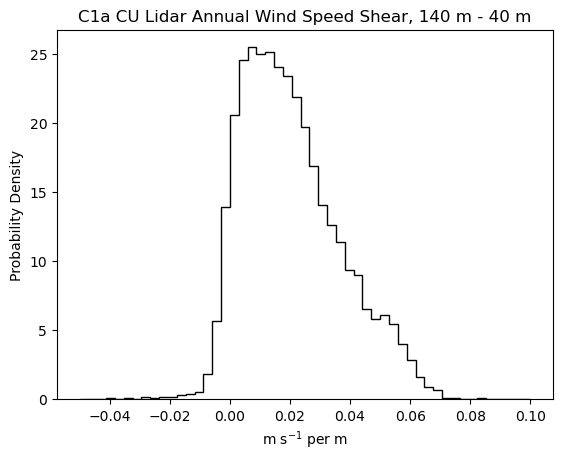

In [22]:
plt.hist(RDshear, bins=51, edgecolor='black', range=[-0.05,0.1],histtype='step',density=True, )

# Add labels and title
plt.xlabel('m s$^{-1}$ per m')
plt.ylabel('Probability Density')
plt.title(RDshear_label)

# Show the plot
plt.show()
